In [59]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [72]:
# Path to Kasthuri++ dataset
data_dir = "dataset\Kasthuri++"
train_images_dir = os.path.join(data_dir, "Train_In")
train_masks_dir = os.path.join(data_dir, "Train_Out")
test_images_dir = os.path.join(data_dir, "Test_In")
test_masks_dir = os.path.join(data_dir, "Test_Out")
PATCH_SIZE = 128

# Prepare training data
train_data = []
train_start_idx = 1031  # Starting index for train masks (mask1031)
for i, image_file in enumerate(os.listdir(train_images_dir)):
    image_path = os.path.join(train_images_dir, image_file)
    mask_path = os.path.join(train_masks_dir, f"mask{train_start_idx + i}.png")
    train_data.append(
        { 
            "image" : image_path, 
            "annotation" : mask_path
        })

# Prepare testing data
test_data = []
test_start_idx = 1041  # Starting index for test masks (mask1041)
for i, image_file in enumerate(os.listdir(test_images_dir)):
    image_path = os.path.join(test_images_dir, image_file)
    mask_path = os.path.join(test_masks_dir, f"mask{test_start_idx + i}.png")
    test_data.append(
        { 
            "image" : image_path, 
            "annotation" : mask_path
        })

print(train_data)

print(test_data)

[{'image': 'dataset\\Kasthuri++\\Train_In\\mask1031.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1031.png'}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1032.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1032.png'}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1033.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1033.png'}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1034.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1034.png'}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1035.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1035.png'}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1036.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1036.png'}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1037.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1037.png'}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1038.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1038.png'}, {'image': 'dataset\\Kasthuri++\\Train_I

In [73]:
# Model definition (UNet-like structure)
class SegmentationModel(nn.Module):
    def __init__(self, num_classes):
        super(SegmentationModel, self).__init__()
        self.encoder = nn.Sequential(
            self.conv_block(3, 32, stride=2),
            self.conv_block(32, 64, stride=2),
            self.conv_block(64, 128, stride=2),
            self.conv_block(128, 256, stride=2),
        )
        self.decoder = nn.Sequential(
            self.upconv_block(256, 128),
            self.upconv_block(128, 64),
            self.upconv_block(64, 32),
            self.upconv_block(32, 32),
        )
        self.final = nn.Conv2d(32, num_classes, kernel_size=3, padding=1)

    def conv_block(self, in_channels, out_channels, stride=1):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        features = []
        for encoder_layer in self.encoder:
            x = encoder_layer(x)
            features.append(x)

        for i, decoder_layer in enumerate(self.decoder):
            x = decoder_layer(x)
            if i < len(self.decoder) - 1:
                x = x + features[-i-2]

        x = self.final(x)
        return x

Kasthuri++ train image size: 1463*1613
            test image size:  1334*1553

In [74]:
# Dataset class
class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, data_list, target_size=(1024, 768), transform=None):
        self.data_list = data_list
        self.target_size = target_size  # Target size for padding
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def resize_with_padding(self, img, target_size, is_mask=False):
        """
        Resize the image with padding to fit the target size without changing the aspect ratio.
        Args:
            img: Input image or mask (numpy array).
            target_size: Tuple of (width, height).
            is_mask: Boolean indicating whether the input is a mask.
        Returns:
            Resized and padded image or mask.
        """
        h, w = img.shape[:2]

        # Calculate the scaling factor to maintain the aspect ratio
        scale = min(target_size[1] / h, target_size[0] / w)
        new_h, new_w = int(h * scale), int(w * scale)

        # Resize the image
        resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_NEAREST if is_mask else cv2.INTER_LINEAR)

        # Create a padded image with the target size, filled with black (zeros)
        if not is_mask:
            padded = np.zeros((target_size[1], target_size[0], 3), dtype=img.dtype)  # RGB padded (black)
        else:
            padded = np.zeros((target_size[1], target_size[0]), dtype=img.dtype)  # Grayscale padded (black)

        # Calculate the padding for top and left
        top = (target_size[1] - new_h) // 2
        left = (target_size[0] - new_w) // 2

        # Place the resized image in the center of the padded image
        padded[top:top + new_h, left:left + new_w] = resized

        return padded

    def __getitem__(self, idx):
        # Load image and mask
        image_path = self.data_list[idx]["image"]
        annotation_path = self.data_list[idx]["annotation"]
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image to RGB
        mask = cv2.imread(annotation_path, cv2.IMREAD_GRAYSCALE)  # Load mask as grayscale

        # Resize with padding
        image = self.resize_with_padding(image, self.target_size)
        mask = self.resize_with_padding(mask, self.target_size, is_mask=True)

        # Normalize image and mask
        image = image.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0

        # Apply transform if provided
        if self.transform:
            image, mask = self.transform(image, mask)

        # Convert image and mask to tensors
        image = torch.from_numpy(image.transpose(2, 0, 1))  # Convert to (C, H, W) format
        mask = torch.from_numpy(mask).unsqueeze(0)  # Convert mask to (1, H, W) format

        return image, mask

# Metrics calculation
def calculate_metrics(pred_mask, true_mask, threshold=0.5):
    pred_mask = (pred_mask > threshold).float()
    intersection = (pred_mask * true_mask).sum()
    union = pred_mask.sum() + true_mask.sum() - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)
    dice = (2.0 * intersection + 1e-7) / (pred_mask.sum() + true_mask.sum() + 1e-7)
    return iou.item(), dice.item()

# Training function
def train_model(model, train_loader, val_loader, num_epochs=50, device="cuda"):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    best_val_iou = 0.0

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_iou, train_dice = 0, 0, 0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            batch_iou, batch_dice = calculate_metrics(torch.sigmoid(outputs), masks)
            train_loss += loss.item()
            train_iou += batch_iou
            train_dice += batch_dice

        avg_train_loss = train_loss / len(train_loader)
        avg_train_iou = train_iou / len(train_loader)
        avg_train_dice = train_dice / len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_train_loss:.4f}, IoU: {avg_train_iou:.4f}, Dice: {avg_train_dice:.4f}")

        if avg_train_iou > best_val_iou:
            best_val_iou = avg_train_iou
            # torch.save(model.state_dict(), "Unet_Kasthuri_best_model.pth")

            
# Inference function
def predict(model, image_path, device="cuda"):
    model.eval()
    
    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (1024, 768))
    
    # Parameters for overlapping patches
    patch_size = PATCH_SIZE
    overlap = patch_size // 2  # 50% overlap
    
    # Calculate steps with overlap
    h_steps = int(np.ceil((768 - patch_size) / (patch_size - overlap))) + 1
    w_steps = int(np.ceil((1024 - patch_size) / (patch_size - overlap))) + 1
    
    patches_list = []
    patch_positions = []  # Store positions for reconstruction
    
    # Extract overlapping patches
    for i in range(h_steps):
        for j in range(w_steps):
            # Calculate patch coordinates
            y_start = min(i * (patch_size - overlap), 768 - patch_size)
            x_start = min(j * (patch_size - overlap), 1024 - patch_size)
            
            # Extract patch
            patch = image[y_start:y_start+patch_size, x_start:x_start+patch_size]
            
            # Normalize and convert channel order
            patch = patch / 255.0
            patch = patch.transpose(2, 0, 1)
            patches_list.append(patch)
            patch_positions.append((y_start, x_start))
    
    # Convert to tensor
    patches_array = np.stack(patches_list)
    patches_tensor = torch.from_numpy(patches_array).float().to(device)
    
    # Run inference
    with torch.no_grad():
        outputs = model(patches_tensor)
        pred_masks = torch.sigmoid(outputs) > 0.5
    
    # Initialize weight and prediction maps
    weight_map = np.zeros((768, 1024))  # here 768 * 1024 is Lucchi++ image size
    pred_map = np.zeros((768, 1024))
    
    # Create weight kernel for blending
    y, x = np.mgrid[0:patch_size, 0:patch_size]
    weight_kernel = np.exp(-((x - patch_size/2)**2 + (y - patch_size/2)**2) / (2*(patch_size/4)**2))
    
    # Reconstruct full mask with weighted averaging
    for idx, (y_start, x_start) in enumerate(patch_positions):
        mask_patch = pred_masks[idx, 0].cpu().numpy()
        
        # Apply weight kernel
        weighted_patch = mask_patch * weight_kernel
        
        # Add to prediction and weight maps
        y_end = min(y_start + patch_size, 768)
        x_end = min(x_start + patch_size, 1024)
        h, w = y_end - y_start, x_end - x_start
        
        pred_map[y_start:y_end, x_start:x_end] += weighted_patch[:h, :w]
        weight_map[y_start:y_end, x_start:x_end] += weight_kernel[:h, :w]
    
    # Normalize by weights
    full_mask = np.divide(pred_map, weight_map, where=weight_map > 0)
    full_mask = (full_mask > 0.5).astype(np.float32)
    
    return full_mask





In [75]:

train_dataset = SegmentationDataset(train_data)
test_dataset = SegmentationDataset(test_data)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# Initialize model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SegmentationModel(num_classes=1).to(device)


In [ ]:
# # Train model
train_model(model, train_loader, test_loader, num_epochs=50, device=device)

Epoch 1/50, Loss: 0.6097, IoU: 0.0644, Dice: 0.1205
Epoch 2/50, Loss: 0.4663, IoU: 0.1614, Dice: 0.2758
Epoch 3/50, Loss: 0.3745, IoU: 0.2836, Dice: 0.4364
Epoch 4/50, Loss: 0.3073, IoU: 0.4402, Dice: 0.6090
Epoch 5/50, Loss: 0.2552, IoU: 0.5086, Dice: 0.6724
Epoch 6/50, Loss: 0.2159, IoU: 0.5490, Dice: 0.7075
Epoch 7/50, Loss: 0.1856, IoU: 0.5844, Dice: 0.7361
Epoch 8/50, Loss: 0.1607, IoU: 0.6178, Dice: 0.7627
Epoch 9/50, Loss: 0.1397, IoU: 0.6498, Dice: 0.7870
Epoch 10/50, Loss: 0.1231, IoU: 0.6739, Dice: 0.8046
Epoch 11/50, Loss: 0.1097, IoU: 0.6963, Dice: 0.8202
Epoch 12/50, Loss: 0.0981, IoU: 0.7196, Dice: 0.8366
Epoch 13/50, Loss: 0.0884, IoU: 0.7362, Dice: 0.8478
Epoch 14/50, Loss: 0.0808, IoU: 0.7449, Dice: 0.8535
Epoch 15/50, Loss: 0.0739, IoU: 0.7603, Dice: 0.8635
Epoch 16/50, Loss: 0.0682, IoU: 0.7620, Dice: 0.8643
Epoch 17/50, Loss: 0.0630, IoU: 0.7699, Dice: 0.8698
Epoch 18/50, Loss: 0.0585, IoU: 0.7807, Dice: 0.8766
Epoch 19/50, Loss: 0.0547, IoU: 0.7890, Dice: 0.8818


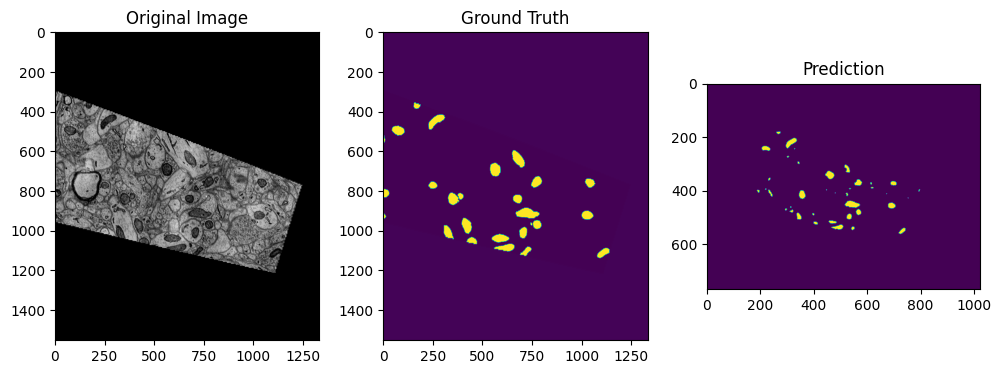

In [68]:
# https://huggingface.co/CompVis/ldm-super-resolution-4x-openimages1
# Example inference
test_image_path = test_data[0]["image"]
pred_mask = predict(model, test_image_path)

# # Visualize results
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(cv2.imread(test_image_path))
plt.title('Original Image')
plt.subplot(132)
plt.imshow(cv2.imread(test_data[0]["annotation"], cv2.IMREAD_GRAYSCALE))
plt.title('Ground Truth')
plt.subplot(133)
plt.imshow(pred_mask)
plt.title('Prediction')
plt.show()



In [70]:
# 保存模型
torch.save(model.state_dict(), "overlaping_unet_segmentation_Kasthuri++.pth")

In [ ]:
# load from oxford_segmentation_models.pth
import torch

def load_model(model_path, num_classes, device):
    # Create an instance of your model
    model = SegmentationModel(num_classes)
    
    # Load the state dict
    state_dict = torch.load(model_path, map_location=device)
    
    # Load the state dict into your model
    model.load_state_dict(state_dict)
    
    # Move the model to the specified device
    model = model.to(device)
    
    # Set the model to evaluation mode
    model.eval()
    
    return model

# Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 1 
model_path = "simple_unet_segmentation.pth"

model = load_model(model_path, num_classes, device)

TypeError: SegmentationModel.__init__() missing 1 required positional argument: 'num_classes'